In [138]:
from cProfile import label
from pyexpat import features

# use repeated Logistic Regression and k-fold cross-validation to select the best features combination
import pandas as pd
from anaconda_project.internal.conda_api import result
from cryptography.hazmat.backends.openssl import backend
from fontTools.misc.classifyTools import classify
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import numpy as np
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [139]:
Xian_cohort = pd.read_csv('/Users/gengzhi/Desktop/Xian_cohort.csv')
nonXian_cohort = pd.read_csv('/Users/gengzhi/Desktop/nonXian_cohort.csv')
Xian_cohort = pd.concat([Xian_cohort, nonXian_cohort])
imputer = KNNImputer(n_neighbors=2)
# only 69th column have missing value
Xian_cohort['CRP'] = imputer.fit_transform(Xian_cohort)[:, 69]
adata = Xian_cohort[Xian_cohort['surgical_classify'] != 1]
# drop the columns that are not needed,include '生存时间‘，’death(死亡)'
adata = adata.drop(['survival_time', 'death'], axis=1)
adata.index = range(0, len(adata))

In [140]:
X = adata.drop('SSUM400', axis=1)
y = adata['SSUM400']

In [141]:
# EO,CRP fit semi-normal distribution, let calculate the std when u=0
EO = X['EO']
CRP = X['CRP']
EO_std = np.sqrt(np.square(EO).sum()/(len(EO)+1))
CRP_std = np.sqrt(np.square(CRP).sum()/(len(CRP)+1))
print(EO_std, CRP_std)

0.1748658452351037 19.26822991505532


In [142]:
# perform log transformation on some columns,including NEUT,SII,EO,BASO,TT,FDP,D_D,AST,ALT,AST_ALT,GGT_Y,CK,TG,HCY,HbA1c,CRP,GLU
X['NEUT_log10'] = np.log10(X['NEUT'])
X['SII_log10'] = np.log10(X['SII'])
X['BASO_log10'] = np.log10(X['BASO']+0.005)
X['TT_log10'] = np.log10(X['TT'])
X['FDP_log10'] = np.log10(X['FDP'])
X['D_D_log10'] = np.log10(X['D_D'])
X['AST_log10'] = np.log10(X['AST'])
X['ALT_log10'] = np.log10(X['ALT'])
X['AST_ALT_log10'] = np.log10(X['AST_ALT'])
X['GGT_Y_log10'] = np.log10(X['GGT_Y'])
X['CK_log10'] = np.log10(X['CK'])
X['TG_log10'] = np.log10(X['TG'])
X['HCY_log10'] = np.log10(X['HCY'])
X['HbA1c_log10'] = np.log10(X['HbA1c'])
X['GLU_log10'] = np.log10(X['GLU'])
for i in ['NEUT', 'SII', 'BASO', 'TT', 'FDP', 'D_D', 'AST', 'ALT', 'AST_ALT', 'GGT_Y', 'CK', 'TG', 'HCY', 'HbA1c', 'GLU']:
    X.drop(i, axis=1, inplace=True)

In [143]:
# divide data in k folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=0)
auc = {}
feature = {}
classify_result = {}
train_index_set = {}
test_index_set = {}
train_set = {}
test_set = {}
for i,(train_index, test_index) in enumerate(kf.split(X)):
    train_index_set[i] = train_index
    test_index_set[i] = test_index
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = StandardScaler()
    features = X.columns
    X_train = pd.DataFrame(X_train, columns=features)
    X_train1 = scaler.fit_transform(X_train.drop(['EO', 'CRP','reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete'], axis=1))
    X_train1 = pd.DataFrame(X_train1, columns=features.drop(['EO', 'CRP','reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete']),index=train_index)
    X_train['EO'] = X_train['EO'] / EO_std
    X_train['CRP'] = X_train['CRP'] / CRP_std
    X_train1['EO'] = X_train['EO'].values
    X_train1['CRP'] = X_train['CRP'].values
    X_train1[['reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete']] = X_train[['reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete']].values
    X_train = X_train1
    train_set[i] = X_train
    X_test = pd.DataFrame(X_test, columns=features)
    X_test1 = scaler.transform(X_test.drop(['EO', 'CRP','reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete'], axis=1))
    X_test1 = pd.DataFrame(X_test1, columns=features.drop(['EO', 'CRP','reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete']),index=test_index)
    X_test['EO'] = X_test['EO'] / EO_std
    X_test['CRP'] = X_test['CRP'] / CRP_std
    X_test1['EO'] = X_test['EO'].values
    X_test1['CRP'] = X_test['CRP'].values
    X_test1[['reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete']] = X_test[['reappear', 'surgical_classify', 'sex', 'stroke_if', 'TIA_if', 'hypertension', 'diabete']].values
    X_test = X_test1
    test_set[i] = X_test
    # use repeated Logistic Regression to select the best features combination
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)
    # get the feature importance
    feature_importance = pd.DataFrame(model.coef_, columns=features)
    # sort the feature importance
    feature_importance = feature_importance.T
    feature_importance = feature_importance.abs().sort_values(by=0, ascending=False)
    auc[i] = []
    feature[i] = {}
    classify_result[i] = {}
    for j in range(0,70):
            # select the top j features
            selected_features = feature_importance.index[:(70-j)]
            # train the model with the selected features
            model.fit(X_train[selected_features], y_train)
            # predict the test data
            y_pred = model.predict_proba(X_test[selected_features])[:,1]
            # calculate the best threshold
            fpr, tpr, threshold = roc_curve(y_test, y_pred)
            best_threshold = threshold[np.argmax(tpr-fpr)]
            classify_result[i][j] = pd.DataFrame((y_pred > best_threshold).astype(int), columns=['predict'+str(j)],index=test_index)
            # calculate the auc
            auc[i].append(roc_auc_score(y_test, y_pred))
            feature[i][j] = selected_features
            features = selected_features
            feature_importance = pd.DataFrame(model.coef_, columns=features)
            # sort the feature importance
            feature_importance = feature_importance.T
            feature_importance = feature_importance.abs().sort_values(by=0, ascending=False)
         
    

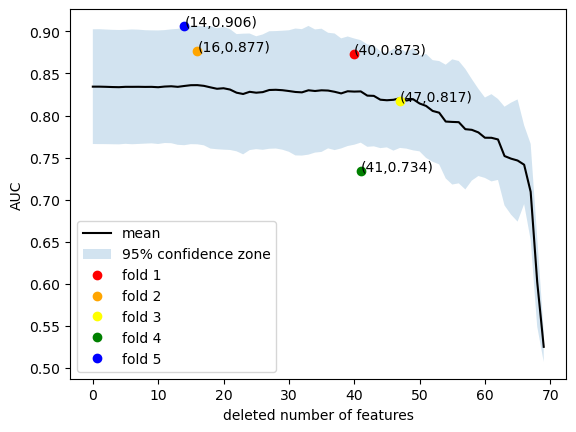

In [144]:
# plot the auc
import matplotlib.pyplot as plt
import numpy as np
auc = pd.DataFrame(auc)
auc0 = auc[0]
auc1 = auc[1]
auc2 = auc[2]
auc3 = auc[3]
auc4 = auc[4]
mean_auc = auc.mean(axis=1)
std_auc = auc.std(axis=1)
plt.plot(np.arange(0,70), mean_auc,c='black')
plt.fill_between(np.arange(0,70), mean_auc-std_auc, mean_auc+std_auc, alpha=0.2)
plt.xlabel('deleted number of features')
plt.ylabel('AUC')
# plot
plt.plot(np.argmax(auc0), np.max(auc0),'o',c='red')
plt.text(np.argmax(auc0), np.max(auc0), '(%d,%.3f)'%(np.argmax(auc0), np.max(auc0)))
plt.plot(np.argmax(auc1), np.max(auc1),'o',c='orange')
plt.text(np.argmax(auc1), np.max(auc1), '(%d,%.3f)'%(np.argmax(auc1), np.max(auc1)))
plt.plot(np.argmax(auc2), np.max(auc2),'o',c='yellow')
plt.text(np.argmax(auc2), np.max(auc2), '(%d,%.3f)'%(np.argmax(auc2), np.max(auc2)))
plt.plot(np.argmax(auc3), np.max(auc3),'o',c='green')
plt.text(np.argmax(auc3), np.max(auc3), '(%d,%.3f)'%(np.argmax(auc3), np.max(auc3)))
plt.plot(np.argmax(auc4), np.max(auc4),'o',c='blue')
plt.text(np.argmax(auc4), np.max(auc4), '(%d,%.3f)'%(np.argmax(auc4), np.max(auc4)))
plt.legend(['mean','95% confidence zone','fold 1','fold 2','fold 3','fold 4','fold 5'])
plt.savefig('/Users/gengzhi/Desktop/feature_selection.pdf',backend='pgf')

In [145]:
t_test = pd.read_csv('/Users/gengzhi/Desktop/t_test.csv', index_col=0)
chi2_test = pd.read_csv('/Users/gengzhi/Desktop/chi2_test.csv',index_col=0)
# get the p-value of t-test and chi2 test
t_test_p = t_test['p_value']
chi2_test_p = chi2_test['p_value']
# output p<0.05 features
t_test_p = t_test_p[t_test_p < 0.05].index
chi2_test_p = chi2_test_p[chi2_test_p < 0.05].index
p_features = set(t_test_p) | set(chi2_test_p)

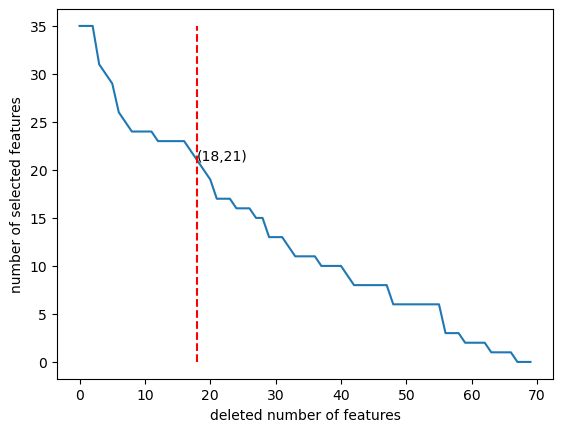

In [146]:
indeed_features_number = {}
auc_2 = {}
feature_importance_2 = {}
for i in range(0,5):
 feature_importance_2[i] = {}
 auc_2[i] = []
 indeed_features_number[i] = []
for i in range(0,5):
 for j in range(0,70):
  # get the best features combination
  best_features0 = feature[0][j]
  best_features1 = feature[1][j]
  best_features2 = feature[2][j]
  best_features3 = feature[3][j]
  best_features4 = feature[4][j]
  common_features = set(best_features0) & set(best_features1) & set(best_features2) & set(best_features3) & set(best_features4)
  indeed_features = set(p_features) & set(common_features)
  # transform indeed_features to list
  indeed_features = list(indeed_features)
  model = LogisticRegression(max_iter=10000)
  y_train = y[train_index_set[i]]
  X_train = train_set[i]
  X_test = test_set[i]
  y_test = y[test_index_set[i]]
  if indeed_features:
    model.fit(X_train[indeed_features], y_train)
    # predict the test data
    y_pred = model.predict_proba(X_test[indeed_features])[:,1]
    # calculate the auc
    auc_2[i].append(roc_auc_score(y_test, y_pred))
    feature_importance_2[i][j] = pd.DataFrame(model.coef_, columns=indeed_features)
    indeed_features_number[i].append(len(indeed_features))
  else: 
    auc_2[i].append(None)
    indeed_features_number[i].append(0)
    feature_importance_2[i][j] = None
plt.plot(np.arange(0,70), indeed_features_number[0])
plt.xlabel('deleted number of features')
plt.ylabel('number of selected features')
plt.vlines(18,0,35,colors='red',linestyles='dashed')
plt.text(18,21,'(%d,%d)'%(18,21))
plt.savefig('/Users/gengzhi/Desktop/feature_number.pdf',backend='pgf')

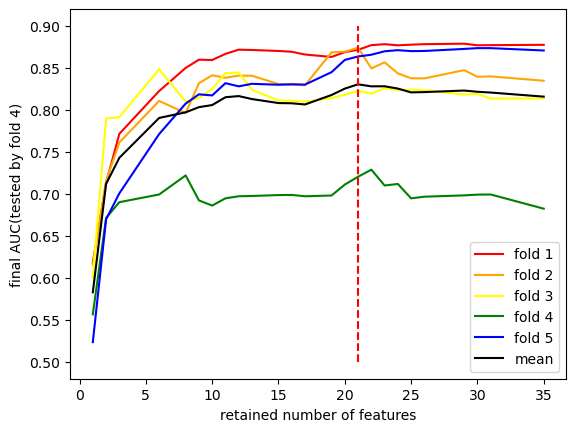

In [147]:
auc_2_mean = []
for j in range(0,70):
    if None in [auc_2[0][j], auc_2[1][j], auc_2[2][j], auc_2[3][j], auc_2[4][j]]:
        auc_2_mean.append(None)
    else:
        auc_2_mean.append(np.mean([auc_2[0][j], auc_2[1][j], auc_2[2][j], auc_2[3][j], auc_2[4][j]]))
plt.plot(indeed_features_number[0], auc_2[0],c='red')
plt.plot(indeed_features_number[0], auc_2[1],c='orange')
plt.plot(indeed_features_number[0], auc_2[2],c='yellow')
plt.plot(indeed_features_number[0], auc_2[3],c='green')
plt.plot(indeed_features_number[0], auc_2[4],c='blue')
plt.plot(indeed_features_number[0], auc_2_mean,c='black')
plt.xlabel('retained number of features')
plt.ylabel('final AUC(tested by fold 4)')
plt.vlines(21,0.5,0.9,colors='red',linestyles='dashed')
plt.legend(['fold 1','fold 2','fold 3','fold 4','fold 5','mean'])
plt.savefig('/Users/gengzhi/Desktop/feature_selection_2.pdf',backend='pgf')

In [148]:
best_features0 = feature[0][18]
best_features1 = feature[1][18]
best_features2 = feature[2][18]
best_features3 = feature[3][18]
best_features4 = feature[4][18]
common_features = set(best_features0) & set(best_features1) & set(best_features2) & set(best_features3) & set(best_features4)
indeed_features = set(p_features) & set(common_features)
indeed_features = pd.DataFrame(indeed_features)
indeed_features.to_csv('/Users/gengzhi/Desktop/indeed_features.csv')

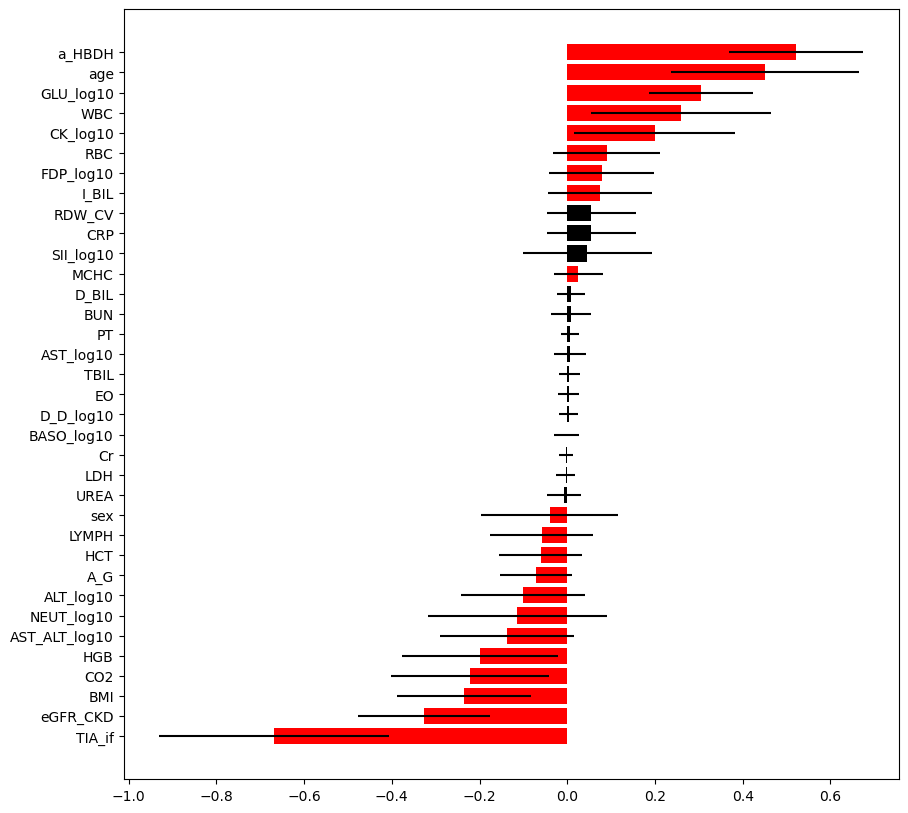

In [154]:
important_data = pd.DataFrame()
for i in range(0,5):
    for j in range(0,70):
        if feature_importance_2[i][j] is not None:
            important_data = pd.concat([important_data, feature_importance_2[i][j].T],axis=1)
important_data= important_data.fillna(0)
index = important_data.index
important_data_plot = pd.DataFrame(np.mean(important_data.values, axis=1), columns=['mean'], index=index)
important_data_plot['std'] = important_data.std(axis=1)
important_data_plot = important_data_plot.sort_values(by='mean', ascending=True)
plt.figure(figsize=(10,10))
# change some y label to red color
important_data_plot['color'] = 'black'
important_data_plot.loc[indeed_features[0],'color'] = 'red'
plt.barh(important_data_plot.index, important_data_plot['mean'], xerr=important_data_plot['std'], color=important_data_plot['color'])
plt.savefig('/Users/gengzhi/Desktop/feature_importance_2.pdf',backend='pgf')

